# Unzip the file in Colab's GPU

In [1]:
!unzip /content/acedatathon19-odometer.zip

unzip:  cannot find or open /content/acedatathon19-odometer.zip, /content/acedatathon19-odometer.zip.zip or /content/acedatathon19-odometer.zip.ZIP.


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/acedatathon19-odometer.zip", 'r')
zip_ref.extractall("/content/sample_data")
zip_ref.close()

# Get all the libraries

In [0]:
%matplotlib inline
import pandas as pd
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Data Loading

In [0]:
train_image_folders = sorted(glob.glob("/content/sample_data/acedatathon19-odometer/train/train/*"))
test_image_folders = sorted(glob.glob("/content/sample_data/acedatathon19-odometer/test/test/*"))

In [102]:
len(train_image_folders), len(test_image_folders)

(3633, 641)

In [0]:
train_labels = pd.read_csv('train_labels.csv', index_col=False, dtype=object)

In [104]:
train_labels.head()

,Image,Label
0,0001,7333
1,0002,49534
2,0003,79129
3,0004,23266
4,0005,52026


In [0]:
def load_images(paths):
    image_files = []

    for f in paths:
        image_files.append(sorted(glob.glob(f +"/*")))

    images = []
    for ff in image_files:
        curr = []
        for f in ff:
            im = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
            curr.append(im)
        images.append(curr)
    return images

In [20]:
%%time
train_images = load_images(train_image_folders)
test_images = load_images(test_image_folders)

CPU times: user 31.3 s, sys: 1.28 s, total: 32.6 s
Wall time: 32.7 s


## Basic preprocessing

In [0]:
def histogram_equalization(images):
    return [cv2.equalizeHist(im) for im in images]

def normalization(images):
    return [(im - np.min(im))/np.ptp(im) for im in images]

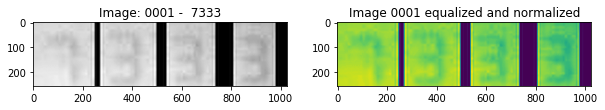

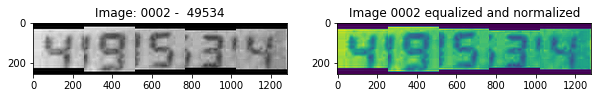

In [107]:
from skimage.color import rgb2gray

for i in range(2):
    fig = plt.figure(figsize=(10, 20))
    ax1 = fig.add_subplot('121')
    images = train_images[i].copy();
    ax1.imshow(np.hstack(images),cmap='gray')
    ax1.set_title(f"Image: {train_labels['Image'].iloc[i]} -  {train_labels['Label'].iloc[i]}")
    ax2 = fig.add_subplot('122')
    for j in range(len(images)):
      images[j] = rgb2gray(images[j])
      letter = train_labels['Label'].iloc[i]
    ax2.imshow(np.hstack(images))
    ax2.set_title(f"Image {train_labels['Image'].iloc[i]} equalized and normalized")
    plt.show()

# Get the Data

In [0]:
images = []
label = []

for i in range(len(train_images)):
  images_row = train_images[i].copy();
  letter = train_labels['Label'].iloc[i]
  for j in range(len(images_row)):
    images.append(images_row[j]);
    label.append(letter[j])

In [109]:
from numpy import zeros, newaxis

images = np.array(images)
#images = images [0:3000]
#images= images.reshape(images.shape[0], -1)
images = images[:, :, :,newaxis]
print (images.shape)
label = np.array(label)
#label = label[0:3000]
print (label.shape)

(18946, 256, 256, 1)
(18946,)


# Train Model

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, label, test_size=0.2, random_state = 100)

In [114]:
import tensorflow as tf

# The StarGAN CNN part
model_cnn = tf.keras.models.Sequential([
        
    tf.keras.layers.Conv2D(32, (4, 4), strides=(2,2), padding='same', input_shape=(256, 256, 1)),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(32, (3, 3), strides=(1,1), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(64, (4, 4), strides=(2,2), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(64, (3, 3), strides=(1,1), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(128, (4, 4), strides=(2,2), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(128, (3, 3), strides=(1,1), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(256, (4, 4), strides=(2,2), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(256, (3, 3), strides=(1,1), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(512, (4, 4), strides=(2,2), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(512, (3, 3), strides=(1,1), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(1024, (4, 4), strides=(2,2), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(1024, (3, 3), strides=(1,1), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.01)
    
])

# The StarGAN output part
model_starGAN_output = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, (2, 2), strides=(1,1)),
    tf.keras.layers.Dense(10,activation=tf.nn.softmax)
])

# Combine the two networks
model_starGAN = tf.keras.models.Sequential([
    model_cnn,
    model_starGAN_output,
    tf.keras.layers.Flatten()
])


# Optimizer, loss function and metric
model_starGAN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_cnn.summary()
model_starGAN_output.summary()
model_starGAN.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_150 (Conv2D)          (None, 128, 128, 32)      544       
_________________________________________________________________
leaky_re_lu_108 (LeakyReLU)  (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
leaky_re_lu_109 (LeakyReLU)  (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 64, 64, 64)        32832     
_________________________________________________________________
leaky_re_lu_110 (LeakyReLU)  (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 64, 64, 64)      

In [0]:
optimizer_adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)

model_starGAN.compile(optimizer=optimizer_adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [123]:
epochs = 10

val_loss = []
loss = []
val_acc = []
acc = []
index = []

for i in range (epochs):
  print(i+1)
  hist = model_starGAN.fit(x_train, y_train, validation_data=(x_test,y_test)) 
  print(hist.history)
  index.append(i+1)
  val_loss.append(hist.history['val_loss'])
  loss.append(hist.history['loss'])
  val_acc.append(hist.history['val_acc'])
  acc.append(hist.history['acc'])

1
Train on 15156 samples, validate on 3790 samples
15156/15156 [==============================] - 67s 4ms/sample - loss: 2.2690 - acc: 0.8207 - val_loss: 2.7751 - val_acc: 0.7219
{'loss': [2.268963391814203], 'acc': [0.82073104], 'val_loss': [2.775112940831046], 'val_acc': [0.72189975]}
2
Train on 15156 samples, validate on 3790 samples
15156/15156 [==============================] - 66s 4ms/sample - loss: 2.2678 - acc: 0.8108 - val_loss: 2.7575 - val_acc: 0.7177
{'loss': [2.2677806633133533], 'acc': [0.810834], 'val_loss': [2.757475285416857], 'val_acc': [0.7176781]}
3
Train on 15156 samples, validate on 3790 samples
15156/15156 [==============================] - 67s 4ms/sample - loss: 2.2685 - acc: 0.8133 - val_loss: 2.7567 - val_acc: 0.7314
{'loss': [2.268497985533782], 'acc': [0.81334126], 'val_loss': [2.75674856885442], 'val_acc': [0.7313984]}
4
Train on 15156 samples, validate on 3790 samples
15156/15156 [==============================] - 67s 4ms/sample - loss: 2.2652 - acc: 0.807

# Get predictions

In [124]:
images = []
lengths = []

for i in range(len(test_images)):
  images_row = test_images[i].copy();
  lengths.append(len(images_row));
  for j in range(len(images_row)):
    images.append(images_row[j]);

images = np.array(images)
#images= images.reshape(images.shape[0], -1)
images = images[:, :, :,newaxis]
print (images.shape)

(3143, 256, 256, 1)


In [0]:
#prediction_numbers = clf.predict(images)
prediction_numbers = np.argmax(model_starGAN.predict(images),axis=1)

In [126]:
print (prediction_numbers[0])

6


In [0]:
predictions = []
index = 0;
for i in range(len(lengths)):
  number = lengths[i]
  s = ""
  for k in range(number):
    s = s + str(prediction_numbers[index]) 
    index = index + 1
  predictions.append(s)

# Extract Results

In [0]:
index = 3634
with open('results_GAN_final_2.txt', 'w') as f:
    f.write("%s\n" % "Image,Label")
    for predict in predictions:
        writing_str = str(index)+','+str(predict)
        f.write("%s\n" % writing_str)
        index = index + 1